$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$

$\newcommand{\R}{\bb{R}}$

$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$

$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2 }}$

# Finite Dimensional Koopman Bilinear System

Consider a nonlinear dynamical system that allows an exact finite dimensional Koopman canonical transform such that the control-affine dynamics can be transformed to a bilinear system. Consider the dynamical system 

\begin{equation}
\mb{\dot{x}}=\mb{f}_0(\mb x) + \mb f_1 ( \mb x) u_1 + \mb f_2(\mb x) u_2, 
\end{equation}

where we for this example choose $\mb f_0, \mb f_1$ as follows:

\begin{equation}
\mb f_0(\mb x) = \begin{bmatrix} x_3 \\ x_4 \\ \lambda x_3 \\ \mu x_4 + (2 \lambda - \mu) c x_3^2 \end{bmatrix}, \qquad
\mb f_1(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}, \qquad
\mb f_2(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 0 \\ x_1+1 \end{bmatrix}, 
\end{equation}   

and $\lambda, \mu, c \in \mathbb{R}$ are scalar parameters of the system. Setting $ \mb x = [q_1 \, q_2 \, \dot{q_1} \, \dot{q_2}]^T$, 
these equations of motion can be expressed as robotic dynamics of the form $\mb{D}(\mb{q})\ddot{\mb{q}} + \mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q}) = \mb{B}\mb{u}$, where $\mb D$ is the inertia matrix, $\mb C$ is the matrix of Coriolis terms, $\mb G$ is the matrix of gravitational terms, and $\mb B$ is the static actuation matrix. Rewriting $\mb f_0, \mb f_1, \mb f_2$ in terms of $\mb D, \mb C, \mb G,$ and $\mb B$ yield



\begin{equation}
\mb D(\mb q) = \begin{bmatrix} 1 & 0\\ 0 &  \frac{1}{q_1+1} \end{bmatrix}, 
\qquad \mb C(\mb q, \mb{\dot{q}}) = -\begin{bmatrix} \lambda & 0 \\ \frac{1}{q_1 + 1}(2 \lambda - \mu) c \dot{q}_1 & \frac{1}{q_1 +1} \mu \end{bmatrix}, \qquad 
\mb G(\mb q) = \begin{bmatrix} 0 \\ 0 \end{bmatrix} 
\qquad \mb B = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix},
\end{equation}

In [1]:
import numpy as np
import sys
sys.path.append('../../../')

# Define experiment parameters

In [2]:
from core.dynamics import RoboticDynamics

class FiniteDimKoopSys(RoboticDynamics):
    def __init__(self, lambd, mu, c):
        RoboticDynamics.__init__(self, 2, 2)
        self.params = lambd, mu, c
    
    def D(self, q):
        return np.array([[1, 0],[0, (q[0]+1)**(-1)]])
    
    def C(self, q, q_dot):
        labmd, mu, c = self.params
        return -np.array([[lambd, 0], [(q[0]+1)**(-1)*(2*lambd - mu)*c*q_dot[0], (q[0]+1)**(-1)*mu]])
    
    def G(self, q):
        return np.array([0, 0])
    
    def B(self, q):
        return np.array([[1, 0], [0, 1]])
    
class FiniteDimKoopSysDiscrete(FiniteDimKoopSys):
    def __init__(self, lambd, mu, c, dt):
        FiniteDimKoopSys.__init__(self, lambd, mu, c)
        self.dt = dt

    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        lambd, mu, c = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 1, 0],
                                            [0, 0, 0, 1],
                                            [0, 0, lambd, 0],
                                            [u0[1], 0, 2*(2*lambd-mu)*c*x0[2], mu]])

        B_lin = self.dt*np.array([[0, 0],
                          [0, 0],
                          [1, 0],
                          [0, x0[0]+1]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin

n, m = 4, 2
lambd, mu, c = .3, .2, -.5
finite_dim_koop_sys = FiniteDimKoopSys(lambd, mu, c)

In [3]:
from koopman_core.dynamics import LinearLiftedDynamics

A_lin = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, lambd, 0],
                  [0, 0, 0, mu]])
B_lin = np.array([[0, 0],
                  [0, 0],
                  [1, 0],
                  [0, 1]])
dt = 1e-2
linearized_sys = LinearLiftedDynamics(A_lin, B_lin, np.eye(n), lambda x: x)

# MPC parameters:
umax = np.array([7.5, 7.5])
umin = -umax
xmax = np.array([6., 6., 5., 5.])
xmin = -xmax
Q_mpc = 1*np.diag([1, 1, 1e-1, 1e-1])
QN_mpc = 1e4*np.eye(n)
R_mpc = np.eye(m)
traj_duration = 2
traj_length = int(traj_duration/dt)

# Design trajectory:
x0 = np.array([0., 0., 0., 0.])
set_pt = np.array([5., 3., 0., 0.])
term_constraint = False

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0, set_pt, int(traj_length)+1)
u_init = np.ones((m,traj_length)).T

# Construct Koopman bilinear form of the system

As a result of the careful construction of this system, there exists a Koopman canonical transform, $\mb z = T(\mb x)$ that exactly transforms the control-affine dynamics into a bilinear system. Consider the transformation:

\begin{equation}
    T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 
    \phi_1(\mb q, \mb{\dot{q}})\\
    \phi_2(\mb q, \mb{\dot{q}})\\
    \phi_3(\mb q, \mb{\dot{q}})\\
    \phi_4(\mb q, \mb{\dot{q}})\\
    \phi_5(\mb q, \mb{\dot{q}})\\
    \phi_6(\mb q, \mb{\dot{q}})\\
    \end{bmatrix}
    = \begin{bmatrix} 
    1\\
    q_1 - \frac{1}{\lambda}\dot{q}_1\\
    q_2 - \frac{1}{\mu} \dot{q}_2 + \frac{(2 \lambda - \mu)c}{2\lambda \mu} \dot{q}_1^2\\
    \dot{q}_1\\
    \dot{q}_2 - c \dot{q}_1^2\\
    \dot{q}_1^2\\
    \end{bmatrix},
\end{equation}

where $\phi_1, \phi_2, \phi_3, \phi_4, \phi_5, \phi_6$ are eigenfunctions of the Koopman operator associated with the drift 
vector field $\mb f_0$. The matrix with the eigenvalue associated with the i-th eigenfunction on the i-th diagonal 
element is $F=\text{diag}(0, 0, \lambda, \mu, 2 \lambda, 0)$. Then, to reformulate the dynamics we have: 

\begin{equation} 
L_{\mb f_1} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0\\ -\frac{1}{\lambda}\\ \frac{(2\lambda - \mu)c}{\lambda \mu}\dot{q}_1\\ 1 \\ -2c\dot{q}_1 \\ 2\dot{q_1} \end{bmatrix}, \qquad 
L_{\mb f_2} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0 \\ 0\\ -\frac{1}{\mu}(q_1 + 1)\\0 \\ q_1 + 1 \\ 0 \end{bmatrix} 
\end{equation}

and the dynamics can be equivalently transformed to a bilinear form $\mb{\dot{z}} = F \mb z + G_1\mb z u_1 + G_2\mb z u_2$ with 

\begin{equation}
F = \begin{bmatrix} 
0 &0 & 0 & 0 & 0 & 0\\  
0 & 0 & 0 & 0 & 0 & 0\\
0 &0 & 0 & 0 & 0 & 0\\
0 &0 & 0 & \lambda & 0 & 0\\
0 &0 & 0 & 0 & \mu & 0 \\
0 &0 & 0 & 0 & 0 & 2 \lambda\\
\end{bmatrix}, \qquad 
G_1 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
-\frac{1}{\lambda}& 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \frac{(2\lambda - \mu)c}{\lambda \mu} & 0 & 0\\
1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & -2c & 0 & 0\\
0 & 0 & 0 & 2 & 0 & 0\\  
\end{bmatrix}
, \qquad 
G_2 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 &  0 & 0 & 0 & 0\\
 -\frac{1}{\mu} & -\frac{1}{\mu} & 0 &  -\frac{1}{\lambda \mu} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & \frac{1}{\lambda} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}
\end{equation}

In [4]:
from koopman_core.dynamics import BilinearLiftedDynamics

F = np.array([[0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, lambd, 0, 0],
              [0, 0, 0, 0, mu, 0],
              [0, 0, 0, 0, 0, 2*lambd]])
G_1 = np.array([[0, 0, 0, 0, 0, 0],
                [-1/lambd, 0, 0, 0, 0, 0],
                [0, 0, 0, (2*lambd - mu)*c/(lambd*mu), 0, 0],
                [1, 0, 0, 0, 0, 0], 
                [0, 0, 0, -2*c, 0, 0], 
                [0, 0, 0, 2, 0, 0]])
G_2 = np.array([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [-1/mu, -1/mu, 0, -1/(lambd*mu), 0, 0],
                [0, 0, 0, 0, 0, 0], 
                [1, 1, 0, 1/lambd, 0, 0], 
                [0, 0, 0, 0, 0, 0]])
G = [G_1, G_2]
phi_fun = lambda x: np.array([1,
                            x[0,0] - 1/lambd*x[0,2],
                            x[0,1] - 1/mu*x[0,3] + (2*lambd - mu)*c/(2*lambd*mu)*x[0,2]**2,
                            x[0,2],
                            x[0,3] - c*x[0,2]**2,
                            x[0,2]**2])
phi_fun_grad = lambda x: np.array([[0., 0., 0., 0.]
                                   [1., 0., -1/lambd, 0.],
                                   [0., 1., (2*lambd-mu)*c/(lambd*mu)*x[0,2], -1/mu],
                                   [0., 0., 1., 0.],
                                   [0., 0., -2*c*x[0,2], 1.],
                                   [0., 0., 2*x[0,2], 0.]])

C_q = np.array([[0, 1, 0, 1/lambd, 0, 0],
                [0, 0, 1, 0, 1/mu, c/mu - ((2*lambd - mu)*c)/(2*lambd*mu)]])
C_qdot = np.array([[0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 1, c]])
C = np.concatenate((C_q, C_qdot), axis=0)
n_koop = 6

koop_bilinear_sys = BilinearLiftedDynamics(n_koop, m, F, G, C, phi_fun)

#### Verify that the Koopman Bilinear Form model and control-affine model are equivalent

To verify that the models are in fact equivalent we sample a random control sequence and simulate both models forward with the same control sequence. As can be seen below, the resulting trajectories are equivalent.

[ 3.14664152e-05 -4.71025293e-05  6.29643125e-03 -9.42370968e-03]
[ 6.37733110e-05 -1.73767565e-04  1.61880652e-04 -1.59114817e-02]
[ 5.42121454e-05 -3.38194736e-04 -2.07523233e-03 -1.69743066e-02]
[ 9.81392585e-05 -5.42900053e-04  1.08671261e-02 -2.39691771e-02]
[ 0.00011144 -0.00072647 -0.00821643 -0.01274013]
[ 7.47442579e-05 -8.24455775e-04  8.81734526e-04 -6.85596560e-03]
[ 0.00010462 -0.00094632  0.00509481 -0.01752072]
[ 0.00014957 -0.00101642  0.00389533  0.0035086 ]
[ 0.00018582 -0.00099039  0.00335517  0.00169557]
[ 0.00014235 -0.00103177 -0.01205667 -0.00997416]
[-1.35118490e-05 -1.18313859e-03 -1.91202313e-02 -2.03033292e-02]
[-0.00022697 -0.00143049 -0.02357443 -0.02917024]
[-0.00052699 -0.001641   -0.03643561 -0.01292619]
[-0.00089397 -0.00174731 -0.03696102 -0.008336  ]
[-0.00120236 -0.00185297 -0.02470997 -0.01279552]
[-0.0014343  -0.00202157 -0.02167621 -0.0209277 ]
[-0.0016143  -0.00230375 -0.01432012 -0.03551178]
[-0.00172598 -0.00263219 -0.00801393 -0.03017548]
[-0.

[ 1.          0.21497948  0.23159424 -0.06931452 -0.05911968  0.0048045 ]
[ 1.          0.21740895  0.18074337 -0.0702527  -0.04904072  0.00493544]
[ 1.          0.24027989  0.13965761 -0.07733537 -0.04074459  0.00598076]
[ 1.          0.25619657  0.1075909  -0.08234989 -0.0342792   0.0067815 ]
[ 1.          0.30373473  0.10652271 -0.09688018 -0.03370759  0.00938577]
[ 1.          0.29283157  0.11334317 -0.09389539 -0.03524463  0.00881634]
[ 1.          0.24675582  0.02306148 -0.08033402 -0.01764262  0.00645356]
[ 1.          0.23461508  0.04201944 -0.0769277  -0.02156889  0.00591787]
[ 1.          0.15984511  0.02861846 -0.05469415 -0.01942188  0.00299145]
[ 1.          0.11644453 -0.04065927 -0.04181876 -0.00580104  0.00174881]
[ 1.          0.10412799 -0.05978997 -0.03824389 -0.00203204  0.0014626 ]
[ 1.          0.12329372 -0.06047409 -0.04411715 -0.00182015  0.00194632]
[ 1.          0.08805101 -0.08017371 -0.03366101  0.00198285  0.00113306]
[ 1.          0.11446417 -0.10370801 -

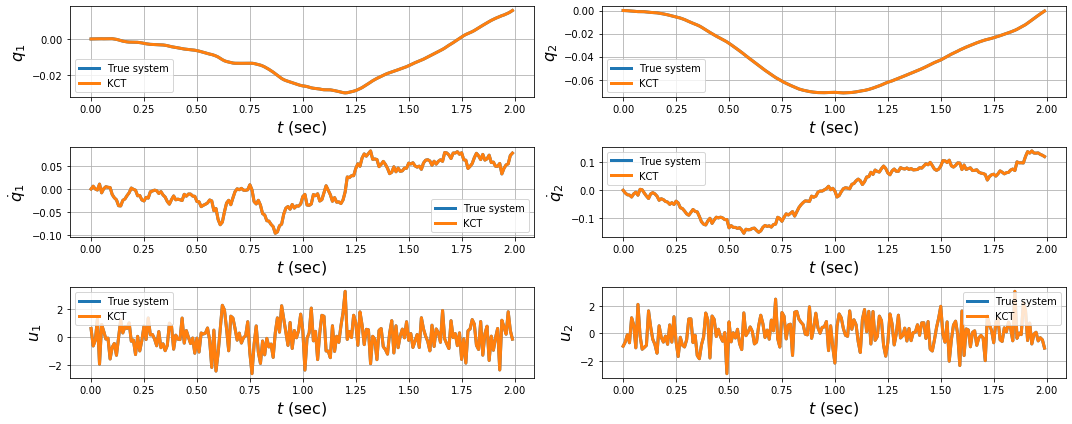

In [5]:
from matplotlib.pyplot import subplots, tight_layout, show
from koopman_core.controllers.openloop_controller import OpenLoopController

ol_controller = OpenLoopController(finite_dim_koop_sys, np.random.normal(size=(2,200)).T, np.arange(0,200)*dt)
z0 = phi_fun(x0.reshape((1,-1)))
xs, us = finite_dim_koop_sys.simulate(x0, ol_controller, np.arange(0,201)*dt)
zs_koop, us_koop = koop_bilinear_sys.simulate(z0, ol_controller, np.arange(0,201)*dt)
xs_koop = np.dot(C, zs_koop.T)

_, axs = subplots(3, 2, figsize=(15, 6))
ylabels = ['$q_1$', '$q_2$', '$\\dot{q}_1$', '$\\dot{q}_2$', '$u_1$', '$u_2$']

for ax, data_fb, data_koop, ylabel in zip(axs.flatten(), np.vstack((xs[:-1,:].T, us.T)), np.vstack((xs_koop[:,:-1], us_koop.T)), ylabels):
    ax.plot(np.arange(0,200)*dt, data_fb, linewidth=3, label='True system')
    ax.plot(np.arange(0,200)*dt, data_koop, linewidth=3, label='KCT')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()
    ax.set_xlabel('$t$ (sec)', fontsize=16)
    ax.legend()
    
tight_layout()
show()

# Design model predictive controllers

#### Linear model predictive controller

In [6]:
from koopman_core.controllers import MPCController

controller_lmpc = MPCController(linearized_sys, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint)

#### Bilinear model predictive controller

In [7]:
from koopman_core.controllers import NonlinearMPCController, BilinearMPCController

# Define rough discrete-time model:
A_d = np.eye(n_koop) + koop_bilinear_sys.A*dt
B_d = [b*dt for b in koop_bilinear_sys.B]
kbf_d = BilinearLiftedDynamics(n_koop, m, A_d, B_d, C, koop_bilinear_sys.basis, continuous_mdl=False, dt=dt)

# Define kbf controller:
controller_knmpc = BilinearMPCController(kbf_d, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint)
z0 = phi_fun(x0.reshape((1,-1)))
z_init = np.array([phi_fun(x.reshape((1,-1))) for x in x_init])
controller_knmpc.construct_controller(z_init, u_init)

#### Nonlinear model predictive controller

In [8]:
finite_dim_koop_sys_d = FiniteDimKoopSysDiscrete(lambd, mu, c, dt)
controller_nmpc = NonlinearMPCController(finite_dim_koop_sys_d, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint)
controller_nmpc.construct_controller(x_init, u_init)

# Evaluate performance of controllers for trajectory generation

#### Design trajectories with the constructed MPCs

In [9]:
max_iter = 50

controller_lmpc.eval(x0, 0)
xr_lmpc = controller_lmpc.parse_result()
ur_lmpc = controller_lmpc.get_control_prediction()

controller_knmpc.solve_to_convergence(z0, 0., z_init, u_init, max_iter=max_iter)
xr_knmpc = koop_bilinear_sys.C@controller_knmpc.get_state_prediction().T
ur_knmpc = controller_knmpc.get_control_prediction().T

controller_nmpc.solve_to_convergence(x0, 0., x_init, u_init, max_iter=max_iter)
xr_nmpc = controller_nmpc.get_state_prediction().T
ur_nmpc = controller_nmpc.get_control_prediction().T

#### Simulate designed trajectories open-loop

In [10]:
from koopman_core.controllers import OpenLoopController
t_eval = np.arange(0,traj_length+1)*dt
ol_controller_lmpc = OpenLoopController(finite_dim_koop_sys, ur_lmpc.T, t_eval[:-1])
xs_lmpc, us_lmpc = finite_dim_koop_sys.simulate(x0, ol_controller_lmpc, t_eval)
xs_lmpc, us_lmpc = xs_lmpc.T, us_lmpc.T

ol_controller_knmpc = OpenLoopController(finite_dim_koop_sys, ur_knmpc.T, t_eval[:-1])
xs_knmpc, us_knmpc = finite_dim_koop_sys.simulate(x0, ol_controller_knmpc, t_eval)
xs_knmpc, us_knmpc = xs_knmpc.T, us_knmpc.T

ol_controller_nmpc = OpenLoopController(finite_dim_koop_sys, ur_nmpc.T, t_eval[:-1])
xs_nmpc, us_nmpc = finite_dim_koop_sys.simulate(x0, ol_controller_nmpc, t_eval)
xs_nmpc, us_nmpc = xs_nmpc.T, us_nmpc.T

[0.00034091 0.00022884 0.06821709 0.0457846 ]
[0.00136064 0.00091259 0.1357612  0.09098383]
[0.00305246 0.00204547 0.20263755 0.13561211]
[0.00540974 0.00362184 0.26885128 0.17968272]
[0.0084258  0.00563618 0.33439239 0.22320788]
[0.01209387 0.00808309 0.3992539  0.26619871]
[0.01640718 0.01095728 0.4634409  0.30866444]
[0.02135902 0.01425353 0.52695846 0.35061272]
[0.02694271 0.01796671 0.58981156 0.39205166]
[0.03315164 0.02209177 0.65200512 0.43298841]
[0.03997923 0.0266237  0.71354403 0.47342918]
[0.04741894 0.03155759 0.77442825 0.51337925]
[0.05546414 0.03688855 0.83464127 0.55284305]
[0.06410813 0.04261172 0.89418791 0.59182418]
[0.07334429 0.04872231 0.95307295 0.63032538]
[0.08316602 0.05521551 1.01130109 0.66834857]
[0.09356676 0.06208656 1.068877   0.70589487]
[0.10454003 0.06933069 1.12580526 0.7429646 ]
[0.11607937 0.07694313 1.18209039 0.77955733]
[0.12817829 0.0849191  1.2377216  0.81567192]
[0.14083022 0.09325382 1.29269293 0.85130657]
[0.1540286  0.10194247 1.34700884 

[0.93757935 0.3586569  3.01268572 1.28894974]
[0.96785922 0.37166165 3.04330338 1.31204636]
[0.99844125 0.3848974  3.07311902 1.33515223]
[1.02931747 0.39836423 3.10213769 1.35826239]
[1.06047991 0.41206215 3.13036428 1.38137134]
[1.09192068 0.42599111 3.15780353 1.40447307]
[1.12363193 0.44015102 3.18446003 1.4275611 ]
[1.15560585 0.4545417  3.21033824 1.45062842]
[1.18783469 0.46916291 3.2354425  1.47366757]
[1.22031073 0.48401432 3.25977697 1.4966706 ]
[1.25302629 0.49909553 3.28334573 1.51962915]
[1.28597372 0.51440606 3.3061527  1.54253436]
[1.31914544 0.52994532 3.32820171 1.56537701]
[1.35253388 0.54571264 3.34949643 1.58814743]
[1.38613151 0.56170725 3.37004046 1.61083559]
[1.41993085 0.57792827 3.38983725 1.63343107]
[1.45392444 0.59437473 3.40889016 1.6559231 ]
[1.48810485 0.61104553 3.42720244 1.6783006 ]
[1.52246471 0.62793948 3.44477725 1.70055215]
[1.55699664 0.64505524 3.46161762 1.72266606]
[1.59169332 0.6623914  3.47772651 1.74463035]
[1.62654745 0.67994638 3.49310677 

[2.23527451 1.01975113 3.64554164 2.13089354]
[2.2717434  1.04114659 3.6482376  2.14827316]
[2.3082358  1.06271385 3.65024406 2.16525163]
[2.34474483 1.08444882 3.65156247 2.18181633]
[2.38126361 1.10634731 3.65219424 2.19795481]
[2.41778529 1.12840499 3.65214071 2.21365484]
[2.45430301 1.15061742 3.65140321 2.22890438]
[2.49080994 1.17298004 3.64998298 2.24369164]
[2.52729927 1.19548816 3.64788126 2.25800505]
[2.56376418 1.21813698 3.64509922 2.27183332]
[2.60019787 1.24092161 3.64163798 2.28516539]
[2.63659357 1.26383703 3.63749866 2.29799051]
[2.67294449 1.28687811 3.63268231 2.31029819]
[2.70924386 1.31003963 3.62718993 2.32207823]
[2.74548494 1.33331627 3.62102252 2.33332074]
[2.78166097 1.35670259 3.61418101 2.34401613]
[2.81776523 1.38019309 3.60666631 2.35415511]
[2.85379098 1.40378216 3.5984793  2.36372872]
[2.8897315  1.42746409 3.58962081 2.37272828]
[2.92558009 1.4512331  3.58009166 2.38114546]
[2.96133003 1.47508334 3.5698926  2.38897222]
[2.99697464 1.49900886 3.5590244  

#### Plot/analyze the results

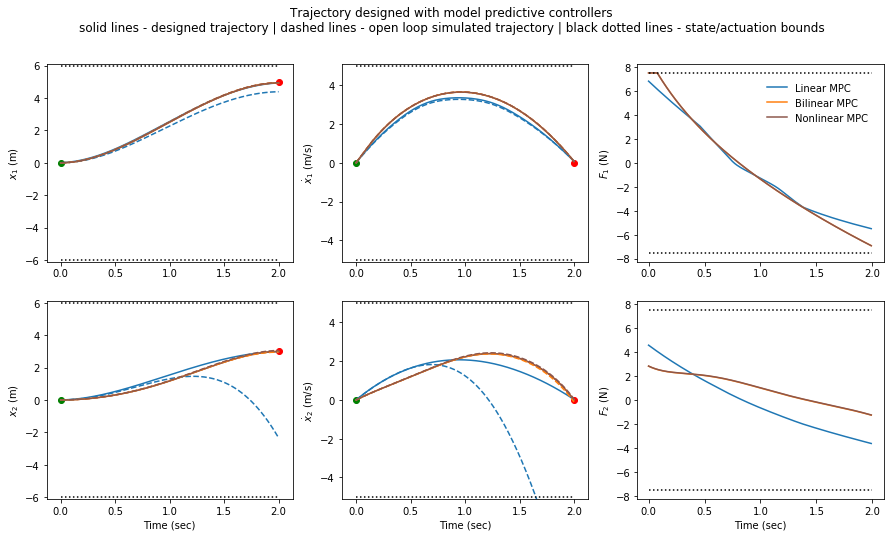

Quadratic cost (normalized by NMPC cost) of designed and realized trajectories designed with each MPC:

                        Designed trajectory    Realized trajectory
--------------------  ---------------------  ---------------------
Linear MPC                         0.971822              379.691
Koopman bilinear MPC               0.99874                 1.01581
Nonlinear MPC                      1                       1


In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tabulate import tabulate

plot_inds = [0, 2, 1, 3, 0, 1]
subplot_inds = [1, 2, 4, 5, 3, 6]
labels = ['$x_1$ (m)', '$x_2$ (m)', '$\\dot{x}_1$ (m/s)','$\\dot{x}_2$ (m/s)','$F_1$ (N)','$F_2$ (N)']
colors = ['tab:blue', 'tab:orange', 'tab:brown']

plt.figure(figsize=(15,8))
plt.suptitle('Trajectory designed with model predictive controllers\nsolid lines - designed trajectory | dashed lines - open loop simulated trajectory | black dotted lines - state/actuation bounds')
for ii in range(6):
    ind = plot_inds[ii]
    if ii < 4:
        plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval, xr_lmpc[ind,:], colors[0], label='Linear MPC')
        plt.plot(t_eval, xr_knmpc[ind, :], colors[1], label='Bilinear MPC')
        plt.plot(t_eval, xr_nmpc[ind,:], colors[2], label='Nonlinear MPC')

        plt.plot(t_eval, xs_lmpc[ind,:], '--', color=colors[0])
        plt.plot(t_eval, xs_knmpc[ind, :], '--', color=colors[1])
        plt.plot(t_eval, xs_nmpc[ind,:], '--', color=colors[2])

        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.scatter(t_eval[0], x0[ind], color='g')
        plt.scatter(t_eval[-1], set_pt[ind], color='r')
        plt.ylabel(labels[ind])
        plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
    else:
        ax = plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval[:-1],ur_lmpc[ind,:], color=colors[0], label='Linear MPC')
        plt.plot(t_eval[:-1], ur_knmpc[ind, :], color=colors[1], label='Bilinear MPC')
        plt.plot(t_eval[:-1],ur_nmpc[ind,:], color=colors[2], label='Nonlinear MPC')
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii]==3:
            plt.legend(loc='upper right', bbox_to_anchor=(0.975, 0.95), frameon=False)
    if subplot_inds[ii] == 4 or subplot_inds[ii] == 5 or subplot_inds[ii] == 6:
        plt.xlabel('Time (sec)')
            
plt.show()

cost_ref_lmpc = (xr_lmpc[:,-1]-set_pt).T@QN_mpc@(xr_lmpc[:,-1]-set_pt) + np.sum(np.diag(ur_lmpc.T@R_mpc@ur_lmpc))
cost_ref_knmpc = (xr_knmpc[:,-1]-set_pt).T@QN_mpc@(xr_knmpc[:,-1]-set_pt) + np.sum(np.diag(ur_knmpc.T@R_mpc@ur_knmpc))
cost_ref_nmpc = (xr_nmpc[:,-1]-set_pt).T@QN_mpc@(xr_nmpc[:,-1]-set_pt) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

cost_ol_lmpc = (xs_lmpc[:,-1]-set_pt).T@QN_mpc@(xs_lmpc[:,-1]-set_pt) + np.sum(np.diag(ur_lmpc.T@R_mpc@ur_lmpc))
cost_ol_knmpc = (xs_knmpc[:,-1]-set_pt).T@QN_mpc@(xs_knmpc[:,-1]-set_pt) + np.sum(np.diag(ur_knmpc.T@R_mpc@ur_knmpc))
cost_ol_nmpc = (xs_nmpc[:,-1]-set_pt).T@QN_mpc@(xs_nmpc[:,-1]-set_pt) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

print('Quadratic cost (normalized by NMPC cost) of designed and realized trajectories designed with each MPC:\n')
print(tabulate([['Linear MPC', cost_ref_lmpc/cost_ref_nmpc, cost_ol_lmpc/cost_ol_nmpc], 
                ['Koopman bilinear MPC', cost_ref_knmpc/cost_ref_nmpc, cost_ol_knmpc/cost_ol_nmpc],
                ['Nonlinear MPC', 1, 1]], 
               headers=['Designed trajectory', 'Realized trajectory']))

#### Study evolution of the solution after each iteration of the SQP-algorithm

[5.00500375e-05 5.00336001e-05 1.00150150e-02 1.00101067e-02]
[0.0002004  0.00020027 0.02006012 0.02004085]
[0.00045135 0.00045092 0.03013541 0.03009288]
[0.00080321 0.0008022  0.04024096 0.04016683]
[0.00125627 0.00125433 0.05037688 0.05026335]
[0.00181085 0.00180755 0.06054325 0.06038308]
[0.00246724 0.00246207 0.07074017 0.07052665]
[0.00322575 0.00321816 0.08096773 0.08069473]
[0.0040867  0.00407605 0.09122601 0.09088794]
[0.00505038 0.00503601 0.10151511 0.10110694]
[0.0061171  0.00609828 0.11183513 0.11135237]
[0.00728718 0.00726314 0.12218615 0.12162488]
[0.00856093 0.00853087 0.13256828 0.13192511]
[0.00993865 0.00990174 0.1429816  0.14225371]
[0.01142067 0.01137604 0.1534262  0.15261134]
[0.01300728 0.01295407 0.16390218 0.16299863]
[0.01469881 0.01463611 0.17440964 0.17341624]
[0.01649558 0.01642249 0.18494867 0.18386481]
[0.01839789 0.01831352 0.19551937 0.194345  ]
[0.02040607 0.0203095  0.20612182 0.20485746]
[0.02252044 0.02241077 0.21675613 0.21540283]
[0.0247413  0.0246

[2.41354245 2.62887067 2.70406273 3.1886255 ]
[2.44067373 2.66088658 2.72220212 3.21457743]
[2.46798667 2.69316264 2.740396   3.2406558 ]
[0.0003462  0.00010184 0.06927422 0.0203741 ]
[0.00138003 0.00040825 0.13752701 0.04091383]
[0.00309133 0.0009208  0.20476566 0.06160116]
[0.00546998 0.00164088 0.27099744 0.08241907]
[0.00850595 0.00256971 0.33622957 0.10335154]
[0.01218928 0.00370836 0.40046922 0.12438341]
[0.01651009 0.00505776 0.46372354 0.14550038]
[0.02145855 0.00661869 0.5259996  0.1666889 ]
[0.02702492 0.0083918  0.58730444 0.1879361 ]
[0.03319951 0.01037761 0.64764507 0.20922977]
[0.03997273 0.01257653 0.70702843 0.23055828]
[0.04733504 0.01498885 0.76546142 0.25191051]
[0.05527695 0.01761476 0.82295092 0.27327585]
[0.06378908 0.02045433 0.87950371 0.29464408]
[0.0728621  0.02350756 0.93512657 0.31600541]
[0.08248672 0.02677431 0.98982622 0.33735036]
[0.09265377 0.03025438 1.04360932 0.35866977]
[0.10335409 0.03394747 1.09648249 0.37995474]
[0.11457864 0.03785319 1.1484523  

[0.04559791 0.0146937  0.73677204 0.24665491]
[0.05324141 0.01726439 0.79195448 0.26748827]
[0.06143213 0.02004335 0.84621654 0.28830879]
[0.0701609  0.0230304  0.89956566 0.30910618]
[0.07941865 0.02622525 0.95200922 0.32987044]
[0.08919634 0.02962753 1.00355452 0.35059183]
[0.09948503 0.03323676 1.0542088  0.37126082]
[0.11027584 0.03705237 1.10397926 0.39186807]
[0.12155998 0.04107369 1.152873   0.4124044 ]
[0.13332871 0.04529998 1.20089708 0.43286075]
[0.14557337 0.04973038 1.24805849 0.45322816]
[0.15828537 0.05436396 1.29436416 0.47349775]
[0.17145618 0.05919971 1.33982095 0.49366069]
[0.18507735 0.0642365  1.38443566 0.51370819]
[0.1991405  0.06947315 1.42821502 0.53363147]
[0.21363729 0.07490836 1.47116571 0.55342177]
[0.22855949 0.08054076 1.51329433 0.57307028]
[0.24389889 0.0863689  1.55460743 0.59256821]
[0.25964739 0.09239121 1.59511149 0.6119067 ]
[0.27579691 0.09860606 1.63481292 0.63107685]
[0.29233947 0.10501173 1.67371808 0.65006972]
[0.30926713 0.11160639 1.71183326 

[0.37137491 0.14038497 2.06537744 0.83508869]
[0.39225545 0.14885795 2.11075377 0.85953121]
[0.41358519 0.15757537 2.15521574 0.88397867]
[0.43535502 0.16653729 2.19877276 0.90843304]
[0.45755595 0.1757438  2.24143405 0.9328959 ]
[0.48017906 0.18519497 2.2832086  0.95736842]
[0.50321553 0.19489092 2.32410522 0.98185134]
[0.52665662 0.20483174 2.36413252 1.00634497]
[0.55049368 0.21501754 2.40329889 1.03084921]
[0.57471814 0.22544843 2.44161257 1.05536347]
[0.59932151 0.23612451 2.47908158 1.07988676]
[0.6242954  0.24704584 2.51571378 1.10441759]
[0.64963146 0.25821251 2.55151685 1.12895406]
[0.67532145 0.26962455 2.58649828 1.15349378]
[0.70135718 0.28128198 2.62066541 1.1780339 ]
[0.72773055 0.2931848  2.6540254  1.20257111]
[0.75443353 0.30533295 2.68658526 1.22710166]
[0.78145813 0.31772634 2.71835183 1.25162131]
[0.80879647 0.33036485 2.74933182 1.27612539]
[0.83644072 0.34324828 2.77953176 1.30060877]
[0.86438309 0.35637642 2.80895804 1.32506587]
[0.89261589 0.36974896 2.83761693 

[0.45120974 0.16450754 2.30594128 0.89201439]
[0.47450015 0.17354545 2.35216552 0.91558912]
[0.49824831 0.18281904 2.39748748 0.93915297]
[0.5224452  0.19232821 2.44191459 0.96270714]
[0.54708194 0.20207288 2.48545407 0.98625244]
[0.57214967 0.21205294 2.52811292 1.00978923]
[0.59763962 0.22226833 2.56989792 1.03331744]
[0.62354308 0.23271895 2.61081567 1.05683659]
[0.64985142 0.2434047  2.65087258 1.08034574]
[0.67655606 0.25432548 2.69007486 1.1038435 ]
[0.70364848 0.26548117 2.72842852 1.12732803]
[0.73112023 0.27687161 2.76593943 1.15079704]
[0.7589629  0.28849665 2.80261326 1.17424777]
[0.78716816 0.30035608 2.83845551 1.19767704]
[0.8157277  0.31244967 2.87347151 1.22108116]
[0.84463331 0.32477716 2.90766646 1.24445604]
[0.87387678 0.33733821 2.94104538 1.2677971 ]
[0.90345    0.35013248 2.97361314 1.29109934]
[0.93334485 0.36315954 3.00537446 1.31435729]
[0.96355332 0.37641892 3.03633395 1.33756509]
[0.99406739 0.38991009 3.06649603 1.36071642]
[1.02487913 0.40363246 3.09586504 

[0.4083876  0.147939   2.23181917 0.84398689]
[0.43095168 0.15649567 2.28102197 0.86736659]
[0.45400332 0.16528617 2.32933016 0.89075168]
[0.47753361 0.17431055 2.37675121 0.9141464 ]
[0.50153371 0.18356895 2.42329238 0.93755462]
[0.52599486 0.1930615  2.46896066 0.96097976]
[0.55090837 0.2027884  2.51376282 0.98442481]
[0.5762656  0.21274985 2.55770539 1.00789232]
[0.60205799 0.2229461  2.60079468 1.03138437]
[0.62827705 0.23337739 2.64303679 1.05490258]
[0.65491431 0.24404399 2.68443759 1.07844809]
[0.68196141 0.25494617 2.72500277 1.10202155]
[0.70941002 0.26608423 2.76473777 1.12562313]
[0.73725185 0.27745843 2.80364789 1.1492525 ]
[0.76547868 0.28906906 2.84173819 1.17290883]
[0.79408235 0.30091637 2.87901358 1.19659079]
[0.82305472 0.31300061 2.91547876 1.22029653]
[0.85238772 0.32532201 2.95113827 1.24402372]
[0.8820733  0.33788076 2.98599648 1.26776949]
[0.91210349 0.35067705 3.02005758 1.2915305 ]
[0.94247032 0.36371099 3.0533256  1.31530289]
[0.97316589 0.37698269 3.08580443 

[0.45322377 0.16484019 2.31521809 0.88334172]
[0.47660633 0.17378802 2.36131585 0.90624405]
[0.50044526 0.18296492 2.40649305 0.92915902]
[0.52473141 0.19237105 2.45075819 0.95209117]
[0.54945569 0.20200661 2.49411954 0.97504458]
[0.5746091  0.21187181 2.53658511 0.99802284]
[0.60018274 0.22196693 2.5781627  1.0210291 ]
[0.62616775 0.23229225 2.61885988 1.044066  ]
[0.65255537 0.24284811 2.65868402 1.0671357 ]
[0.6793369  0.25363482 2.69764224 1.09023981]
[0.70650373 0.26465275 2.73574149 1.11337948]
[0.73404728 0.27590224 2.77298849 1.1365553 ]
[0.76195908 0.28738367 2.80938979 1.15976733]
[0.7902307  0.29909739 2.84495171 1.18301512]
[0.81885378 0.31104375 2.87968042 1.20629767]
[0.84782    0.3232231  2.9135819  1.22961343]
[0.87712114 0.33563575 2.94666192 1.25296033]
[0.906749   0.34828201 2.97892612 1.27633573]
[0.93669545 0.36116215 3.01037994 1.29973649]
[0.96695242 0.37427639 3.04102868 1.3231589 ]
[0.99751187 0.38762493 3.07087745 1.34659873]
[1.02836584 0.40120794 3.09993123 

[1.41795677 0.56469023 3.24543369 1.52472719]
[1.45049507 0.58003318 3.26223558 1.5439152 ]
[1.48319812 0.59556727 3.27838233 1.56295767]
[1.51605938 0.61129101 3.29387752 1.58184428]
[1.54907236 0.62720278 3.30872462 1.60056448]
[1.58223058 0.64330087 3.32292702 1.61910752]
[1.61552762 0.65958344 3.33648801 1.63746246]
[1.64895708 0.67604856 3.34941078 1.6556182 ]
[1.6825126  0.69269419 3.36169847 1.67356348]
[1.71618783 0.70951816 3.3733541  1.69128692]
[1.74997648 0.72651819 3.38438062 1.70877704]
[1.78387226 0.7436919  3.39478092 1.72602225]
[1.81786893 0.76103678 3.40455777 1.74301088]
[1.85196026 0.7785502  3.41371392 1.75973124]
[1.88614007 0.79622942 3.422252   1.77617155]
[1.92040218 0.81407159 3.4301746  1.79232007]
[1.95474046 0.83207373 3.43748423 1.808165  ]
[1.98914878 0.85023273 3.44418334 1.8236946 ]
[2.02362105 0.8685454  3.45027431 1.83889714]
[2.05815121 0.88700839 3.45575945 1.85376095]
[2.0927332  0.90561828 3.46064104 1.86827442]
[2.127361   0.92437149 3.46492125 

[1.76648192 0.75886004 3.54698878 1.87442479]
[1.80201087 0.77771091 3.55880586 1.89581923]
[1.83765442 0.79677457 3.56990931 1.91698507]
[1.87340544 0.81604869 3.58030138 1.93790903]
[1.90925685 0.83553076 3.58998425 1.95857772]
[1.94520155 0.85521818 3.59896003 1.97897772]
[1.98123248 0.87510819 3.60723074 1.99909557]
[2.01734261 0.89519789 3.61479836 2.0189178 ]
[2.05352491 0.91548427 3.6216648  2.03843097]
[2.08977237 0.93596417 3.6278319  2.05762166]
[2.12607803 0.9566343  3.63330144 2.0764765 ]
[2.1624349  0.97749123 3.63807514 2.0949822 ]
[2.19883604 0.9985314  3.64215467 2.11312557]
[2.23527451 1.01975113 3.64554164 2.13089354]
[2.2717434  1.04114659 3.6482376  2.14827316]
[2.3082358  1.06271385 3.65024406 2.16525163]
[2.34474483 1.08444882 3.65156247 2.18181633]
[2.38126361 1.10634731 3.65219424 2.19795481]
[2.41778529 1.12840499 3.65214071 2.21365484]
[2.45430301 1.15061742 3.65140321 2.22890438]
[2.49080994 1.17298004 3.64998298 2.24369164]
[2.52729927 1.19548816 3.64788126 

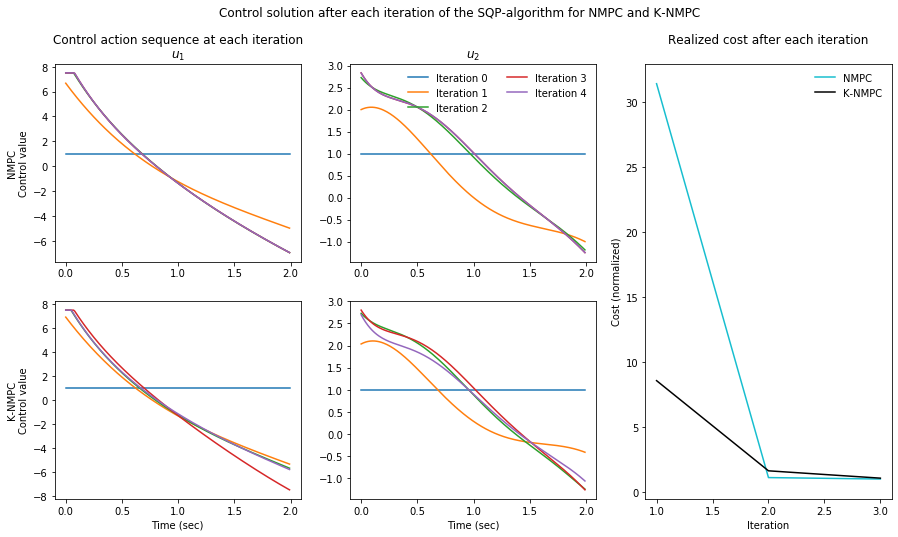

Solution statistics

                        Number of SQP    Mean comp. time per    Std comp. time per    Total comp.
                           iterations       iteration (secs)      iteration (secs)    time (secs)
--------------------  ---------------  ---------------------  --------------------  -------------
Nonlinear MPC                       4             0.0247791             0.00128862      0.0991166
Koopman bilinear MPC               45             0.00832586            0.00181915      0.374664


In [12]:
n_iter = min(len(controller_nmpc.x_iter),len(controller_knmpc.x_iter))

# Calculate cost after each iteration:
iter_cost_nmpc, iter_cost_knmpc = [], []

ol_controller_init = OpenLoopController(finite_dim_koop_sys, u_init, t_eval[:-1])
xs_init, _ = finite_dim_koop_sys.simulate(x0, ol_controller_init, t_eval)
xs_init, us_init = xs_init.T, u_init.T
init_cost = (xs_init[:,-1]-set_pt).T@QN_mpc@(xs_init[:,-1]-set_pt) + np.sum(np.diag(us_init.T@R_mpc@us_init))
iter_cost_nmpc = [init_cost]
iter_cost_knmpc = [init_cost]

for ii in range(n_iter):
    ur_knmpc_iter = controller_knmpc.u_iter[ii].T
    ol_controller_knmpc_iter = OpenLoopController(finite_dim_koop_sys, ur_knmpc_iter, t_eval[:-1])
    xs_knmpc_iter, _ = finite_dim_koop_sys.simulate(x0, ol_controller_knmpc_iter, t_eval)
    xs_knmpc_iter, us_knmpc_iter = xs_knmpc_iter.T, ur_knmpc_iter.T
    iter_cost_knmpc.append((xs_knmpc_iter[:,-1]-set_pt).T@QN_mpc@(xs_knmpc_iter[:,-1]-set_pt) + np.sum(np.diag(us_knmpc_iter.T@R_mpc@us_knmpc_iter)))
    
    ur_nmpc_iter = controller_nmpc.u_iter[ii].T
    ol_controller_nmpc_iter = OpenLoopController(finite_dim_koop_sys, ur_nmpc_iter, t_eval[:-1])
    xs_nmpc_iter, _ = finite_dim_koop_sys.simulate(x0, ol_controller_nmpc_iter, t_eval)
    xs_nmpc_iter, us_nmpc_iter = xs_nmpc_iter.T, ur_nmpc_iter.T
    iter_cost_nmpc.append((xs_nmpc_iter[:,-1]-set_pt).T@QN_mpc@(xs_nmpc_iter[:,-1]-set_pt) + np.sum(np.diag(us_nmpc_iter.T@R_mpc@us_nmpc_iter)))

plt.figure(figsize=(15,8))
plt.suptitle('Control solution after each iteration of the SQP-algorithm for NMPC and K-NMPC')
ax1 = plt.subplot(2,3,1)
ax1.plot(t_eval[:-1],u_init[:, 0])
ax2 = plt.subplot(2,3,2)
ax2.plot(t_eval[:-1],u_init[:, 1], label='Iteration 0')
ax3 = plt.subplot(2,3,4)
ax3.plot(t_eval[:-1],u_init[:, 0])
ax4 = plt.subplot(2,3,5)
ax4.plot(t_eval[:-1],u_init[:, 0])

for it in range(n_iter):
    ax1.plot(t_eval[:-1],controller_nmpc.u_iter[it][0,:])
    ax2.plot(t_eval[:-1],controller_nmpc.u_iter[it][1,:], label='Iteration '+str(it+1))
    ax3.plot(t_eval[:-1],controller_knmpc.u_iter[it][0,:])
    ax4.plot(t_eval[:-1],controller_knmpc.u_iter[it][1,:])
    
ax5 = plt.subplot(1,3,3)
ax5.plot(np.arange(1,n_iter), iter_cost_nmpc[1:n_iter]/iter_cost_nmpc[-1], 'tab:cyan', label='NMPC')
ax5.plot(np.arange(1,n_iter), iter_cost_knmpc[1:n_iter]/iter_cost_nmpc[-1], 'k', label='K-NMPC')

ax1.set_title('Control action sequence at each iteration\n$u_1$')
ax1.set_ylabel('NMPC\nControl value')
ax2.set_title('$u_2$')
ax2.legend(ncol=2, loc='upper right', frameon=False)
ax3.set_ylabel('K-NMPC\nControl value')
ax3.set_xlabel('Time (sec)')
ax4.set_xlabel('Time (sec)')
ax5.set_title('Realized cost after each iteration\n')
ax5.set_xlabel('Iteration')
ax5.set_ylabel('Cost (normalized)')
ax5.legend(loc='upper right', frameon=False)

plt.show()

print('Solution statistics\n')
print(tabulate([['Nonlinear MPC', len(controller_nmpc.x_iter), np.mean(controller_nmpc.comp_time), np.std(controller_nmpc.comp_time), sum(controller_nmpc.comp_time)],
                ['Koopman bilinear MPC', len(controller_knmpc.x_iter), np.mean(controller_knmpc.comp_time), np.std(controller_knmpc.comp_time), sum(controller_knmpc.comp_time)]], 
               headers=['Number of SQP\niterations','Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)', 'Total comp.\ntime (secs)']))

# Evaluate performance of controllers for closed-loop control

#### Design finite horizon controllers

In [13]:
Q_mpc_cl = 5e2*np.diag([1, 1, 1e-1, 1e-1])
QN_mpc_cl= 1e3*np.eye(n)
R_mpc_cl = np.eye(m)
traj_duration = 0.5
N_cl = int(traj_duration/dt)

controller_lmpc_cl = MPCController(linearized_sys, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, terminal_constraint=term_constraint)
controller_knmpc_cl = BilinearMPCController(kbf_d, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, terminal_constraint=term_constraint)
controller_knmpc_cl.construct_controller(controller_knmpc.cur_z[:N_cl+1,:], controller_knmpc.cur_u[:N_cl,:])
controller_nmpc_cl = NonlinearMPCController(finite_dim_koop_sys_d, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, terminal_constraint=term_constraint)
controller_nmpc_cl.construct_controller(controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:])

In [14]:
controller_knmpc_cl.solve_to_convergence(z0, 0., controller_knmpc.cur_z[:N_cl+1,:], controller_knmpc.cur_u[:N_cl,:], max_iter=max_iter)
controller_nmpc_cl.solve_to_convergence(x0, 0., controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:], max_iter=max_iter)

#### Simulate designed trajectories closed-loop

In [15]:
xs_lmpc_cl, us_lmpc_cl = finite_dim_koop_sys.simulate(x0, controller_lmpc_cl, t_eval)
xs_lmpc_cl, us_lmpc_cl = xs_lmpc_cl.T, us_lmpc_cl.T

controller_knmpc_cl.comp_time = []
xs_knmpc_cl, us_knmpc_cl = finite_dim_koop_sys.simulate(x0, controller_knmpc_cl, t_eval)
xs_knmpc_cl, us_knmpc_cl = xs_knmpc_cl.T, us_knmpc_cl.T

controller_nmpc_cl.comp_time = []
xs_nmpc_cl, us_nmpc_cl = finite_dim_koop_sys.simulate(x0, controller_nmpc_cl, t_eval)
xs_nmpc_cl, us_nmpc_cl = xs_nmpc_cl.T, us_nmpc_cl.T

[0.00037537 0.00037528 0.07511245 0.07508389]
[0.00150309 0.00150232 0.15046822 0.15035746]
[0.0033855  0.00338316 0.2260513  0.22584979]
[0.00602478 0.00602011 0.30184353 0.30158557]
[0.00942322 0.00941587 0.3778817  0.37761575]
[0.01358318 0.01357349 0.45414884 0.45396519]
[0.01850696 0.01849635 0.53064505 0.53066978]
[0.02419685 0.02418817 0.6073711  0.60776178]
[0.03065515 0.030653   0.68432797 0.68527743]
[0.03788418 0.03789524 0.7615165  0.76325013]
[0.04588626 0.04591964 0.83893717 0.84171384]
[0.0546637  0.05473127 0.91659044 0.92070333]
[0.06421884 0.06433557 0.9944772  1.00025244]
[0.07455402 0.07473829 1.07259797 1.08039412]
[0.08567159 0.08594555 1.15095374 1.16116634]
[0.09757378 0.09796383 1.22952504 1.24260314]
[0.11026297 0.11079993 1.30835196 1.32473601]
[0.12374161 0.12446099 1.38741603 1.40760056]
[0.13801208 0.1389545  1.46671762 1.49123212]
[0.15307676 0.15428831 1.54625772 1.57566546]
[0.16893804 0.17047059 1.62603706 1.66093372]
[0.1855983  0.18750989 1.70605579 

[4.88518745 2.89853527 0.34802899 0.20990654]
[4.88861631 2.90061291 0.33773832 0.20562207]
[4.89194376 2.90264814 0.32774547 0.20142421]
[4.89517272 2.90464182 0.31804223 0.19731127]
[4.89830606 2.90659478 0.30862061 0.19328157]
[0.00037538 0.00037526 0.07511261 0.07508068]
[0.00150309 0.00150227 0.15046754 0.15035349]
[0.0033854  0.00338302 0.22603223 0.22583642]
[0.00602449 0.00601984 0.30182396 0.30157166]
[0.00942264 0.00941541 0.3778434  0.37759338]
[0.01358212 0.01357277 0.45409125 0.45393577]
[0.01850522 0.01849531 0.53056818 0.53063306]
[0.02419425 0.02418673 0.60727489 0.6077195 ]
[0.03065149 0.03065111 0.68421206 0.68522938]
[0.03787926 0.03789285 0.76138039 0.763197  ]
[0.04587987 0.04591669 0.83878058 0.84165671]
[0.05465565 0.05472773 0.91641331 0.92064285]
[0.06420891 0.06433142 0.99427929 1.00018984]
[0.07454201 0.07473352 1.07237922 1.08033206]
[0.08565728 0.08594016 1.1507138  1.16110396]
[0.09755707 0.09795781 1.22928374 1.24253999]
[0.11024374 0.11079328 1.30808974 

[0.00037531 0.00037521 0.07510016 0.07506909]
[0.00150285 0.0015021  0.15044585 0.15034305]
[0.00338494 0.00338275 0.2260098  0.22582576]
[0.00602381 0.00601946 0.30180144 0.30156109]
[0.00942173 0.00941492 0.37782078 0.3775829 ]
[0.01358099 0.01357218 0.45406856 0.45392523]
[0.01850387 0.01849461 0.53054542 0.53062244]
[0.02419266 0.02418593 0.60725206 0.60770881]
[0.03064968 0.0306502  0.68418917 0.68521859]
[0.03787722 0.03789183 0.76135752 0.7631861 ]
[0.0458776  0.04591556 0.83875743 0.84164624]
[0.05465314 0.05472651 0.91639018 0.92063266]
[0.06420618 0.06433009 0.99425616 1.00017998]
[0.07453904 0.07473209 1.07235602 1.08032206]
[0.08565408 0.08593863 1.15069037 1.16109407]
[0.09755364 0.09795618 1.22926016 1.24253031]
[0.11024007 0.11079156 1.30806609 1.32466478]
[0.12371575 0.12445192 1.38710879 1.40753233]
[0.13798304 0.13894477 1.46638898 1.49116749]
[0.15304432 0.15427795 1.54590748 1.57560498]
[0.16890198 0.17045965 1.62566478 1.66087896]
[0.18555842 0.18749843 1.70566186 

[4.99119929 2.99749095 0.10565436 0.06167707]
[4.99220614 2.9981237  0.09571084 0.06487366]
[4.99311704 2.99877929 0.08646389 0.06624657]
[4.99393881 2.99943975 0.07788664 0.06584486]
[4.99467802 3.00008778 0.06995108 0.06376071]
[4.99534093 3.00070721 0.06262835 0.06012512]


#### Plot/analyze the results

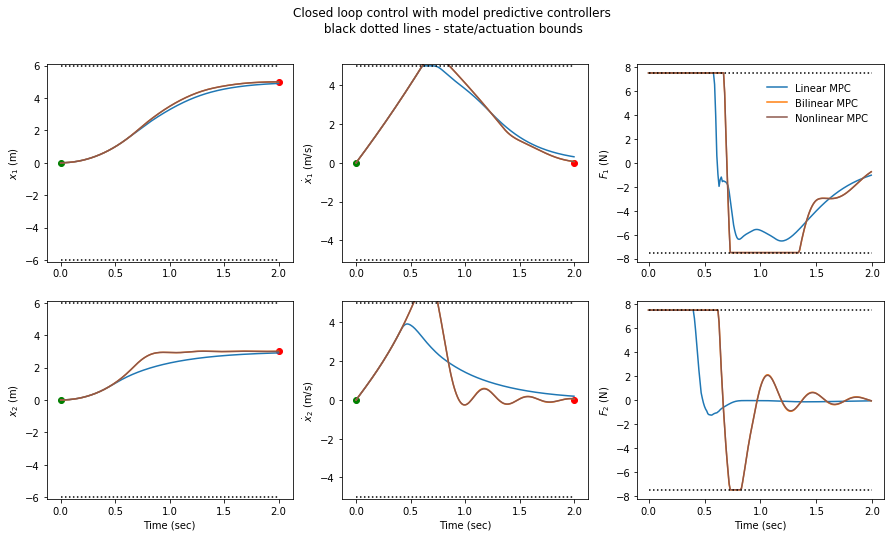


Solution statistics:

                        Quadratic cost    Mean comp. time per    Std comp. time per
                          (normalized)       iteration (secs)      iteration (secs)
--------------------  ----------------  ---------------------  --------------------
Linear MPC                     0.83073             0.00035375           0.000200587
Koopman bilinear MPC           1.00095             0.00240832           0.000557765
Nonlinear MPC                  1                   0.00737611           0.00103189


In [16]:
plot_inds = [0, 2, 1, 3, 0, 1]
subplot_inds = [1, 2, 4, 5, 3, 6]
labels = ['$x_1$ (m)', '$x_2$ (m)', '$\\dot{x}_1$ (m/s)','$\\dot{x}_2$ (m/s)','$F_1$ (N)','$F_2$ (N)']
colors = ['tab:blue', 'tab:orange', 'tab:brown']

plt.figure(figsize=(15,8))
plt.suptitle('Closed loop control with model predictive controllers\n black dotted lines - state/actuation bounds')
for ii in range(6):
    ind = plot_inds[ii]
    if ii < 4:
        plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval, xs_lmpc_cl[ind,:], colors[0], label='Linear MPC')
        plt.plot(t_eval, xs_knmpc_cl[ind, :], colors[1], label='Bilinear MPC')
        plt.plot(t_eval, xs_nmpc_cl[ind,:], colors[2], label='Nonlinear MPC')
        
        #plt.plot(t_eval, xr_lmpc[ind,:], '--', color=colors[0], linewidth=1)
        #plt.plot(t_eval, xr_knmpc[ind, :], '--', color=colors[1], linewidth=1)
        #plt.plot(t_eval, xr_nmpc[ind,:], '--', color=colors[2], linewidth=1)

        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.scatter(t_eval[0], x0[ind], color='g')
        plt.scatter(t_eval[-1], set_pt[ind], color='r')
        plt.ylabel(labels[ind])
        plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
    else:
        ax = plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval[:-1],us_lmpc_cl[ind,:], color=colors[0], label='Linear MPC')
        plt.plot(t_eval[:-1], us_knmpc_cl[ind, :], color=colors[1], label='Bilinear MPC')
        plt.plot(t_eval[:-1],us_nmpc_cl[ind,:], color=colors[2], label='Nonlinear MPC')
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii]==3:
            plt.legend(loc='upper right', bbox_to_anchor=(0.975, 0.95), frameon=False)
    if subplot_inds[ii] == 4 or subplot_inds[ii] == 5 or subplot_inds[ii] == 6:
        plt.xlabel('Time (sec)')
            
plt.show()

cost_cl_lmpc = np.sum(np.diag((xs_lmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_lmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_lmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_lmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_lmpc_cl.T@R_mpc@us_lmpc_cl))
cost_cl_knmpc = np.sum(np.diag((xs_knmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_knmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_knmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_knmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_knmpc_cl.T@R_mpc@us_knmpc_cl))
cost_cl_nmpc = np.sum(np.diag((xs_nmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_nmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_nmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_nmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_nmpc_cl.T@R_mpc@us_nmpc_cl))


print('\nSolution statistics:\n')
print(tabulate([['Linear MPC', cost_cl_lmpc/cost_cl_nmpc, np.mean(controller_lmpc_cl.comp_time), np.std(controller_lmpc_cl.comp_time)],
                ['Koopman bilinear MPC', cost_cl_knmpc/cost_cl_nmpc, np.mean(controller_knmpc_cl.comp_time), np.std(controller_knmpc_cl.comp_time)], 
                ['Nonlinear MPC', cost_cl_nmpc/cost_cl_nmpc, np.mean(controller_nmpc_cl.comp_time), np.std(controller_nmpc_cl.comp_time)]],
               headers=['Quadratic cost\n(normalized)', 'Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)']))